In [1]:
# -*- coding: UTF-8 -*-
import os
import csv
import sys
import math
import pandas as pd
import numpy as np
from random import random
from keras.layers import Dropout, LSTM, Dense, Activation, Embedding, GRU
from keras.models import Sequential
from keras.optimizers import RMSprop

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)
/home/mlgpu/Workspace/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [ ]:
"""
 다른 디바이스에서 사용하기
with tf.device('/gpu:0'):
광역으로 with tf.device('/gpu:' + GPUNUM): 멕이고
세션 선언시
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
** CUDA_VISIBLE_DEVICES=2 
> watch nvidia-smi # GPU 감시
"""

In [2]:
"""
    GET DATA LIST ON FOLDER
    * Input value   : folder
    * Process       : open .csv files from folder, get sensor list and sort
    * Return value  : Pandas DataFrame
"""
def get_data_list_on_folder(folder, complete_set=False):
    folder_list = os.listdir(folder)
    data_list = []

    # get item list from folder
    for csvs in folder_list:
        with open(str(folder + '/' + csvs), 'r') as csvfile:
            i = 0
            sensor_data = csv.reader(csvfile, quotechar='"')
            for data in sensor_data:
                data_list.append(data)
                i += 1
                if (i % 100000 == 0):
                    sys.stdout.write('\r%s, Loading %dK list.' % (csvs, i/1000))
                    sys.stdout.flush()
            print('\n%s, %d line process done.' % (csvs, i))

    # print & sort data / Sort by a time
    print('Sorting...')
    data_list = sorted(data_list, key=lambda data_list:data_list[1])
    print('Set Dataframe...')
    # set dataframe on pandas
    Dust = []
    Light = []
    VoC = []
    Co2 = []
    Temp = []
    Humid =[]
    # uncertain value
    E = []
    Oxy = []
    X = []
    R = []
    M = []
    j = 0
    for sensor in data_list:
        kind = sensor[6] # D,L,V,C,T,H
        value = sensor[4]
        try:
            value = float(sensor[4])
        except ValueError:
            j += 1
            # if value is NULL skip that line
            continue
        if (kind == "D"):
            Dust.append(value)
        elif (kind == "L"):
            Light.append(value)
        elif (kind == "V"):
            VoC.append(value)
        elif (kind == "C"):
            Co2.append(value)
        elif (kind == "T"):
            Temp.append(value)
        elif (kind == "H"):
            Humid.append(value)
        elif (kind == "E"):
            E.append(value)
        elif (kind == "O"):
            Oxy.append(value)
        elif (kind == "X"):
            X.append(value)
        elif (kind == "R"):
            R.append(value)
        elif (kind == "M"):
            M.append(value)
        else:
            print("[Warning] sensor error in %s. Please check commons.py 58 line." % str(sensor))
    print("[Note] Result <D: %d, L: %d, V: %d, C: %d, T: %d, H: %d, E: %d, O: %d, X: %d, R: %d, M: %d>" %
          (len(Dust), len(Light), len(VoC), len(Co2), len(Temp), len(Humid), len(E), len(Oxy), len(X), len(R), len(M)))
    print("[Note] %d number of value is NULL" % (j))
    # Setting Data
    if (complete_set is False):
        # 6 items: DLVCTH
        min_line = min(len(Dust), len(Light), len(VoC), len(Co2), len(Temp), len(Humid))
        min_line -= 1
        data = pd.DataFrame({"D": Dust[:min_line], "L": Light[:min_line], "V": VoC[:min_line], "C": Co2[:min_line],
                            "T": Temp[:min_line], "H": Humid[:min_line]})
    elif (complete_set is True):
        # 11 items: DLVCTH + EOXRM
        min_line = min(len(Dust), len(Light), len(VoC), len(Co2), len(Temp), len(Humid), len(E), len(Oxy), len(X), len(R), len(M))
        min_line -= 1
        data = pd.DataFrame({"D": Dust[:min_line], "L": Light[:min_line], "V": VoC[:min_line], "C": Co2[:min_line],
                            "T": Temp[:min_line], "H": Humid[:min_line], "E": E[:min_line], "O": Oxy[:min_line],
                            "X": X[:min_line], "R": R[:min_line], "M": M[:min_line]})

    print('[DONE] Returned %d items from %s' % (len(data_list), folder))
    return data

"""
    _load_data
    * Note: Data should be pd.DataFrame()
    * Input value:
        - data = pd.DataFrame()
        - n_prev = # of previous consider value (Default is 100) as a Learning Set (like corpus)
    * Output value:
        - training matrix(numpy array)
"""
def _load_data(data, n_prev = 100):
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix()) # data.iloc
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

"""
    train_test_split
"""
def train_test_split(df, fold_size=0.1, time_steps=100):
    print('[Note] Setting Train/Test set separation.')
    ntrn = round(len(df) * (1 - fold_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev=time_steps)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev=time_steps) # df.iloc
    print('X_train.shape: %s' % str(X_train.shape))
    print('y_train.shape: %s' % str(y_train.shape))
    print('[DONE] Train/Test set ready.')
    return (X_train, y_train), (X_test, y_test)

def data_separation():
    print('Operating data separation module.')
    with open('160920_sensor.csv', 'r') as csvfile:
        sensor_data = csv.reader(csvfile, quotechar='"')
        i = 0
        for row in sensor_data:
            id = '160921_sensor'
            # Check header & separator
            # About 32,650,000 Lines
            if(i==0):
                header_list = row
            else:
                # id, time, user, serial, value, ip, type, user2
                separator = str(row[5])
                id = id + separator + '.csv'
            i += 1

            # open and write 'row'
            writer = ''
            try:
                f = open(id, 'a')#, newline='')
                writer = csv.DictWriter(f, fieldnames=header_list)
            except IOError: # FileNotFoundError
                print(separator + ' ip generated.')
                f = open(id, 'w+')#, newline='')
                writer = csv.DictWriter(f, fieldnames=header_list)
                writer.writeheader()
            writer.writerow({'id': row[0], 'time': row[1], 'user': row[2],
                             'serial': row[3], 'value': row[4], 'ip': row[5],
                             'type': row[6],'user2': row[7]})
            f.close()
            if(i%100000 == 0):
                sys.stdout.write('%.2f%% is done.' % (float(i)/32650000)*100)
                sys.stdout.flush()
    return 1

"""
    Get close vector for estimation
"""
def get_close_vector(vector, real_data, model_data, print_out=True):
    # set mapping to model, model to mapping vector
    if(len(real_data) == len(model_data)):
        if(print_out is True):
            print("[Note] Calculating...")
        vec_val = vector.sum()
        vec_idx = -1
        min_val = np.amax(model_data, axis=0).sum()
        for i in range(len(model_data)):
            temp_val = abs(model_data[i].sum() - vector.sum())
            if(temp_val < min_val):
                min_val = temp_val
                vec_idx = i
            else:
                continue
        if(vec_idx != -1):
            if(print_out is True):
                print("[Note] D: %.2f, L: %.2f, V: %.2f, C: %.2f, T: %.2f, H: %.2f" % 
                      (real_data[vec_idx][0], real_data[vec_idx][1], real_data[vec_idx][2], real_data[vec_idx][3],
                  real_data[vec_idx][4], real_data[vec_idx][5]))
            return real_data[vec_idx]
        else:
            print("[Error] Cannot find close list from model. Please Checkout <get_close_vector()>")
            return None
    else:
        print("[Error] Cannot creat mapping list. Because number of lists are not match. (%d, %d)" %(len(real_data), len(model_data)))
        return None
    print("[Warning] Somethings got wrong. Please check <create_mapping_function>.")
    return None

In [3]:
"""
    Testset Module: timesteps to learn and fold
"""
number_of_time_stamps = 128
# Set general LSTM Data from keras
data = get_data_list_on_folder(folder='./ips/sk-jung-gu', complete_set=False)
(X_train, y_train), (X_test, y_test) = train_test_split(data, fold_size=0.1, time_steps=number_of_time_stamps)


160921_sensor1.225.5.24.csv, 5404 line process done.

160921_sensor59.14.19.207.csv, 34 line process done.
160921_sensor59.11.85.58.csv, Loading 21700K list.
160921_sensor59.11.85.58.csv, 21776029 line process done.
Sorting...
Set Dataframe...
[Note] Result <D: 1580009, L: 438604, V: 333005, C: 610461, T: 3243596, H: 2662967, E: 12772979, O: 28738, X: 2752, R: 83332, M: 24862>
[Note] 162 number of value is NULL
[DONE] Returned 21781467 items from ./ips/sk-jung-gu
[Note] Setting Train/Test set separation.
X_train.shape: (299576, 128, 6)
y_train.shape: (299576, 6)
[DONE] Train/Test set ready.


In [4]:
# D L V C T H
print(np.shape(X_train[0])) # check value (timesteps, vectors)
print(X_train[0][0], type(X_train[0][0][0])) # predicted shape
print(y_train[0], type(y_train[0][0])) # predicted shape
print(np.mean(y_train, axis=0))
print("\n")
print(np.shape(X_test[0]))
print(X_test[0][0], type(X_test[0][0][0]))
print(y_test[0], type(y_test[0][0]))
print(np.mean(y_test, axis=0))

(128, 6)
(array([  850. ,   139. ,    25.4,  1023. ,    21.5,   200. ]), <type 'numpy.float64'>)
(array([ 820. ,  294. ,   30.1,  693. ,   22.7,  100. ]), <type 'numpy.float64'>)
[  671.51503124  4726.23268606    30.55859314   436.80005074    21.84991955
   967.3454716 ]


(128, 6)
(array([ 447. ,    9. ,   30.2,  702. ,   22.2,  676. ]), <type 'numpy.float64'>)
(array([ 390. ,   15. ,   30.2,  640. ,   22.8,  798. ]), <type 'numpy.float64'>)
[ 369.27149403   30.83570481   37.48353129  288.6922103    20.99273182
  578.14017846]


In [5]:
"""
    model.output_shape == (None, 32)
    - Input shape   : 3D tensor (nb_samples, timesteps, input_dim)
    - Output shape  : return_sequences 2D tensor is (nb_samples, output_dim)
    - Note: https://keras.io/layers/recurrent/
"""
in_out_neurons = 6
hidden_neurons = 128
batch_size = 256
# X_train.shape    # (# of samples, timesteps, output_dim)
in_shape = (batch_size, number_of_time_stamps, in_out_neurons) # (batch_size, timesteps, input_dim)
model_GRU = Sequential()
model_GRU.add(GRU(output_dim=hidden_neurons,
                    batch_input_shape=(batch_size, number_of_time_stamps, in_out_neurons),
                    activation="sigmoid",
                    return_sequences=True))
# model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(output_dim=hidden_neurons,
                    batch_input_shape=(batch_size, number_of_time_stamps, hidden_neurons),
                    activation="sigmoid",
                    return_sequences=False))
# model_GRU.add(Dropout(0.2))
# model_GRU.add(Dense(hidden_neurons, W_regularizer=l2(0.06)))
model_GRU.add(Dense(output_dim=in_out_neurons, input_dim=hidden_neurons)) # None batches means any size of batch is able to process.
model_GRU.add(Activation("softmax")) # softmax relu sigmoid tanh linear.. https://keras.io/activations/

model_GRU.compile(loss="poisson", optimizer="adam") 
# loss        : https://keras.io/objectives/#available-objectives 
# optimizers  : https://keras.io/optimizers/#usage-of-optimizers
# metrics=['accuracy'], optimizer = "sgd, rmsprop"
# Example: https://keras.io/getting-started/sequential-model-guide/
model_GRU.fit(X_train, y_train, batch_size=batch_size, nb_epoch=3, validation_data=(X_test, y_test), verbose=1) # batch_size / validation_split=0.05
# test model
print("[NOTE] Run on test set:")
score = model_GRU.evaluate(X_test, y_test, batch_size=batch_size, show_accuracy=True, verbose=1)
print("GRU test accuracy: %.2f%%" % (score[1]*100))
print("Done.")

Train on 299576 samples, validate on 33172 samples
Epoch 1/3
299576/299576 [==============================] - 232s - loss: 551.2225 - val_loss: 265.7193
Epoch 2/3
299576/299576 [==============================] - 233s - loss: 507.3424 - val_loss: 264.7159
Epoch 3/3
299576/299576 [==============================] - 233s - loss: 500.8763 - val_loss: 266.0798
[NOTE] Run on test set:
33172/33172 [==============================] - 7s     
GRU test accuracy: 75.58%
Done.


In [6]:
# X_test with the batch_size >> predicted point
predicted = model_GRU.predict(X_test, batch_size=batch_size)
print(np.sqrt((predicted - y_test) ** 2).mean(axis=0)).mean() # Printing RMSE
# Check shape
print(np.shape(predicted))
print(np.shape(y_test))
print(predicted[10])
print(np.mean(predicted, axis=0))
print(y_test[10])
print(np.mean(y_test, axis=0))

220.740816249
(33172, 6)
(33172, 6)
[ 0.19550057  0.009425    0.01624096  0.39774352  0.01062691  0.37046295]
[ 0.33954381  0.03513723  0.02237358  0.19573286  0.01575719  0.39145533]
[ 382.    24.    34.9  912.    21.3  631. ]
[ 369.27149403   30.83570481   37.48353129  288.6922103    20.99273182
  578.14017846]


In [7]:
# check error minimum
err_list = []
for i in range(len(predicted)):
    err = 0
    for j in range(len(predicted[i])):
        err += abs(predicted[i][j] - y_test[i][j])
    if(err <= 450):
        print('[Note] min error index is %d. %s vs %s.' % (i, str(predicted[i]), str(y_test[i])))
    err_list.append(err)
print('[DONE] Check error done, min error is <%.2f>. Max error is <%.2f>.' % (min(err_list), max(err_list)))

[Note] min error index is 17374. [ 0.48859236  0.0340452   0.0323561   0.00307703  0.02201971  0.41990951] vs [   8.    25.    39.     0.    21.7  333. ].
[Note] min error index is 20264. [ 0.4486118   0.02846539  0.02591869  0.35684887  0.01649384  0.12366135] vs [   2.    35.    32.7  177.    22.7  171. ].
[Note] min error index is 21596. [ 0.59009403  0.08588427  0.03019528  0.00755457  0.02335136  0.26292059] vs [ 242.    28.    33.     0.    19.5  128. ].
[DONE] Check error done, min error is <425.71>. Max error is <3566.20>.


In [18]:
a = get_close_vector(vector=predicted[3], real_data=y_test, model_data=predicted, print_out=True)
print(y_test[3])
print(a)

output = np.array([])
for i in range(len(predicted)):
    sys.stdout.write('\rMake output list: %.4f%%. Keep going!' % ((float(i)/len(predicted))*100))
    sys.stdout.flush()
    if i == 0:
        output = get_close_vector(vector=predicted[i], real_data=y_test, model_data=predicted, print_out=False)
    else:
        output = np.vstack((output, get_close_vector(vector=predicted[i], real_data=y_test, model_data=predicted, print_out=False)))
print('Done!')
print(len(output))

[Note] Calculating...
[Note] D: 383.00, L: 9.00, V: 35.20, C: 640.00, T: 20.50, H: 1040.00
[  383.      9.     35.2   640.     20.5  1040. ]
[  383.      9.     35.2   640.     20.5  1040. ]
Make output list: 100.00%. Keep going!Done!
33172


<type 'numpy.ndarray'>
(30, (30,), (33172,))


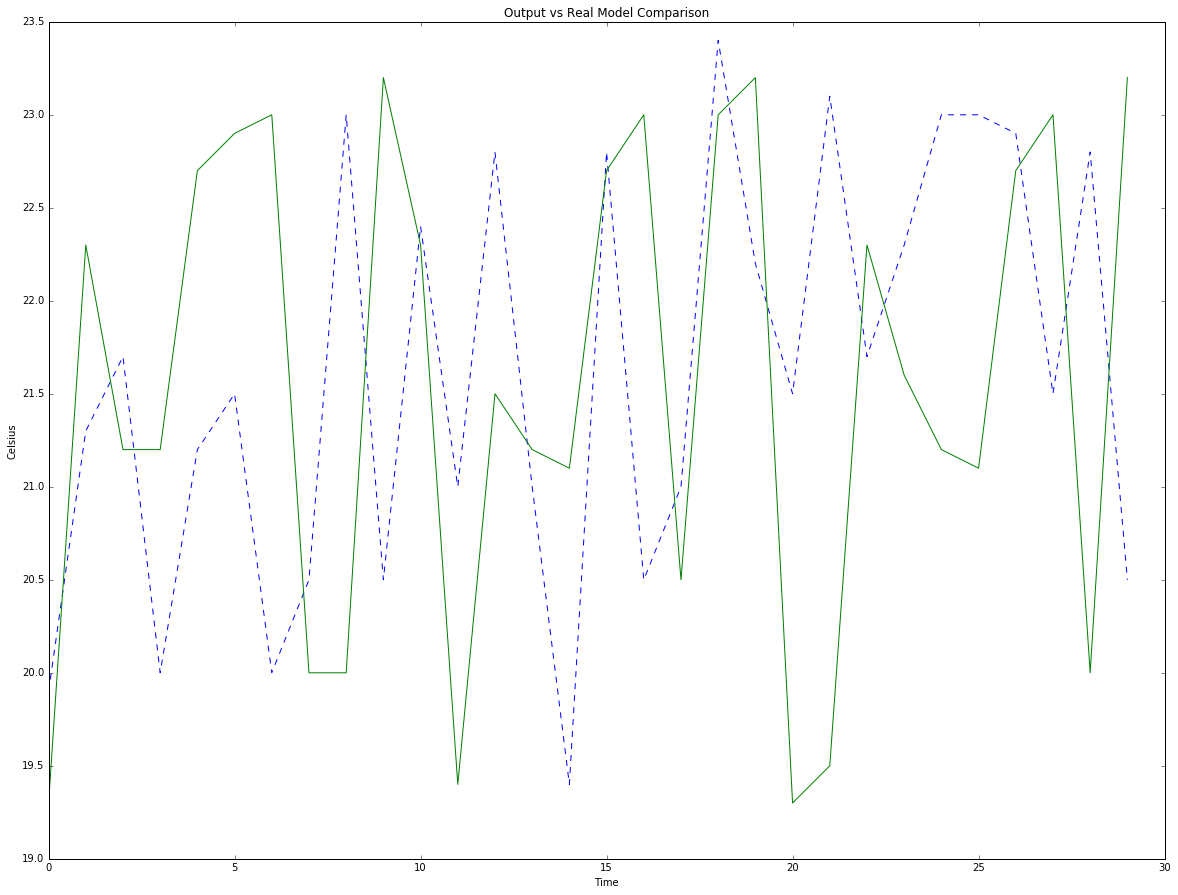

In [62]:
#Print out data
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

start = 1970
cut_size = 2000
# Index to Search <0: Dust>, <1: Light>, <2: VoC>, <3: Co2>, <4: Temperature>, <5: Humidity>
index_to_search = 4 

data_len = len(y_test[start:cut_size])
x = np.arange(data_len)
o = output[start:cut_size,index_to_search]
y = y_test[start:cut_size,index_to_search]

print(type(y))
print(data_len, np.shape(y), np.shape(output[:,index_to_search]))
plt.figure(figsize=(20, 15))
line, = plt.plot(x, o, '--', linewidth=1, label="Estimation")
line, = plt.plot(x, y, '-', linewidth=1, label="Real Data")
plt.xlabel('Time')
plt.ylabel('Celsius')
plt.title('Output vs Real Model Comparison')

plt.show()